# **PROYECTO HUMOR** Modelo Binario usando un LLM

**Autores:**

* Juan Camilo Acosta Rojas - 202324893
* Samuel Goncalves Vergara - 202122595
* Jefferson Hernández - 202120242
* Juan Andrés Mendez - 201815808

In [67]:
# Importación de librerias de python
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re

# Scikit-learn: División de datos y otras utilidades para machine learning
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

# Conexión con drive para obtener el dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1. Carga de los datos**

Primero, se extraen los 10000 datos chistosos y los otros 10000 datos no chistosos. En total son 20000 registros.

In [68]:
url_graceful_dataset = "/content/drive/MyDrive/proyecto NLP/humor_dataset.csv"
url_non_graceful_dataset = "/content/drive/MyDrive/proyecto NLP/datosNochistosos.csv"

df_graceful = pd.read_csv(url_graceful_dataset)
df_non_graceful = pd.read_csv(url_non_graceful_dataset)

dataset = pd.concat([df_graceful, df_non_graceful])
dataset['Es_gracioso'] = dataset['Es_gracioso'].fillna(0)

# Se muestra 5 ejemplos aleatorios del dataset donde la columna "Es_gracioso" indica si es chistoso o no.
print(dataset.shape)
dataset.sample(n=3)

(20000, 20)


,id,text,Fuente,es_gracioso_p1,es_gracioso_p2,es_gracioso_p3,Es_gracioso,nivel_gracia_p1,nivel_gracia_p2,nivel_gracia_p3,is_humor,votes_no,votes_1,votes_2,votes_3,votes_4,votes_5,humor_rating,humor_mechanism,humor_target
8938,8939,j1bbha_The chad yaguareté Coquí vs The Virgin ...,Imágenes/Internet,1.0,1.0,1.0,1.0,2.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3088,tweet4711,Ahora que no hay nadie a quien pueda molestar ...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,4.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
7101,tweet10713,"Keloke con lo que digannnn, yo no cambio eso e...",NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,3.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


## **2. Preprocesamiento de los datos**

Segundo, para el preprocesamiento usamos varios pasos. Primero se reemplazan URLs, menciones de usuarios, hashtags y emojis por tokens genéricos (<URL'>, <USUARIO'>, <HASH_TAG'>, <EMOJI'>), lo que reduce la dimensionalidad del texto sin perder contexto. Además, se convierte todo a minúsculas para uniformidad, se eliminan signos de puntuación y nombres de archivos irrelevantes.

In [69]:
"""
Función para limpiar un texto (chiste) que entra por parámetro
"""
def preprocess_text(text):
    # Transformación de las URLs a su token <URL>
    text = re.sub(r'http\S+', '<URL>', text)

    # Transformación de las menciones de usaurio a su token <USUARIO>
    text = re.sub(r'@\w+', '<USUARIO>', text)

    # Dejar en miniscula el texto
    text = text.lower()

    # Eliminar emojis
    text = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]+', '', text)
    text = re.sub(r':\)|;\)|:-\)|:-\(|:-\(|:-\*|:-\)|:P|:D|:<|:-P', '<EMOJI>', text)

    # Transformación de los hashtags a su token <HASH_TAG>
    text = re.sub(r'#\w+', '<HASH_TAG>', text)

    # Eliminar puntuación
    text = re.sub(r'[^\w\s]', '', text)

    # Transformación de las imagenes a su token <IMAGE>
    result = re.sub(r"[\w-]+\.(jpg|jpeg|png|gif):", "<IMAGE>", text)

    return text

dataset['text'] = dataset['text'].apply(preprocess_text)
dataset = dataset[['text', 'Es_gracioso']]
dataset.sample(n=3)

,text,Es_gracioso
8389,dbaaod_titlejpg un hombre y una mujer besándos...,1.0
5374,las clases de baile siempre parecen fáciles cu...,1.0
4905,señor ilumíname para que el material del exame...,0.0


## **3. Partición de los datos**

Tercero, se realiza una revisión de la distribuión de los datos para verificar un correcto balanceo de las clases.

In [70]:
"""
Función para graficar la distribución de los datos
"""
def graficar_distribucion(class_counts):
    plt.figure(figsize=(6, 4))
    ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette="Blues_d", hue=class_counts.index)

    # Añadir los números sobre las barras
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    fontsize=12, color='black',
                    xytext=(0, 5), textcoords='offset points')

    plt.title("Distribución de Clases en el Conjunto de Datos")
    plt.xlabel("Clase")
    plt.ylabel("Número de Muestras")
    plt.xticks(rotation=0)
    plt.legend([], [], frameon=False)
    plt.show()

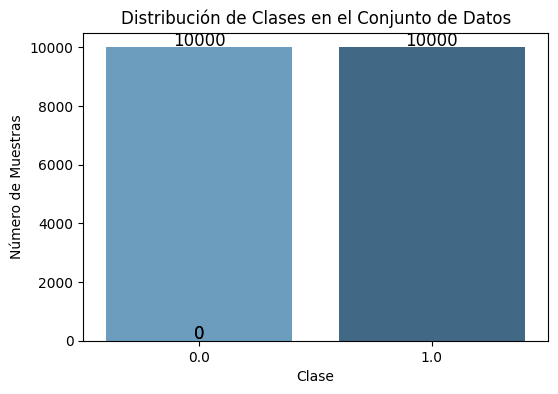

In [71]:
# Distribución de los datos de cada clase
graficar_distribucion(dataset['Es_gracioso'].value_counts())

Una vez verificado el correcto balanceo de las clase, se hace la partición de los datos dejando un 70% de los datos para entrenamiento, un 15% de los datos para validación y un 15% de los datos para prueba.

In [72]:
# Divide el dataset original en un cojunto entrenamiento y un conjunto auxliar
X_train, X_aux, y_train, y_aux = train_test_split(
    dataset['text'],
    dataset['Es_gracioso'],
    random_state=2024,
    test_size=0.3,
    stratify=dataset['Es_gracioso']
)

# Divide el conjunto auxiliar en un cojunto de prueba y un cojunto de validación
X_val, X_test, y_val, y_test = train_test_split(
    X_aux,
    y_aux,
    random_state=2024,
    test_size=0.5,
    stratify=y_aux
)

Ahora vamos a tomar los datos de prueba y se los vamos a pasar al LLM para que los prediga y hacer la misma comparación que con los otros modelos.

La comparación se realiza sobre el conjunto de datos X_test y no sobre todo el dataset porque X_test representa un subconjunto separado y exclusivo reservado para la evaluación de modelos. Este conjunto no se utiliza durante el entrenamiento, lo que asegura que las predicciones realizadas por los modelos sean evaluadas sobre datos nuevos, replicando un escenario real de generalización. Al aplicar las métricas sobre X_test, tanto para el modelo tradicional como para el modelo basado en GPT-4o, garantizamos que las evaluaciones estén bajo las mismas condiciones, evitando sesgos y permitiendo una comparación justa. Usar todo el dataset incluiría datos que pudieron haber sido utilizados para entrenar o ajustar el modelo, lo que comprometería la validez de las métricas al inflar artificialmente los resultados. Por lo tanto, trabajar con X_test asegura una evaluación más objetiva y confiable.

In [73]:
print(X_test.sample(n=5))

8867    13bvyd2_ctm_ctmjpg una captura de pantalla de ...
1253    HASH_TAG entra un japones a violar a una princ...
9714    xoixml_bonkjpg un pájaro está parado junto a u...
3831    doctor me veo muy gorda no sea exagerada mujer...
9677     que ganas de estar jugando gueguitos en la compu
Name: text, dtype: object


Generamos el dataset que se pasará al LLM (en este caso gpt-4o)

In [74]:
X_test.to_excel('Xtest_dataset.xlsx', index=False)

## **4. Generación predicciones usando LLM**


Para generar la clasificación lo que se hizo fue subir el archivo excel al modelo y user el siguiente prompt usando la técnica de few shot para mejorar los resultados:

In [91]:
# Combina las características y etiquetas del conjunto de prueba en un DataFrame
df_test = pd.DataFrame({'text': X_test, 'Es_gracioso': y_test})

# Filtra y toma cinco ejemplos de cada clase para el primer DataFrame
df_clase_0 = df_test[df_test['Es_gracioso'] == 0].sample(n=5)
df_clase_1 = df_test[df_test['Es_gracioso'] == 1].sample(n=5)

# Crea dos DataFrames separados
df_ejemplos_clase_0 = df_clase_0.reset_index(drop=True)
df_ejemplos_clase_1 = df_clase_1.reset_index(drop=True)

# Tomamos los ejemplos de cada clase
ejemplos_chistosos = df_ejemplos_clase_1['text'].tolist()
ejemplos_no_chistosos = df_ejemplos_clase_0['text'].tolist()

# Construimos el prompt
prompt = f"""
El siguiente excel tiene una columna "text" donde hay diferentes datos de texto sobre contenido humorístico, necesito que clasifiques cada chiste con un "sí" en caso de que el contenido sea chistoso, y "no" en caso de que el contenido no sea chistoso.
Ejemplos:
###
Texto:{ejemplos_chistosos[0]}
Clasificación:sí
###
Texto:{ejemplos_chistosos[1]}
Clasificación:sí
###
Texto:{ejemplos_chistosos[2]}
Clasificación:sí
###
Texto:{ejemplos_chistosos[3]}
Clasificación:sí
###
Texto:{ejemplos_chistosos[4]}
Clasificación:sí
###
Texto:{ejemplos_no_chistosos[0]}
Clasificación:no
###
Texto:{ejemplos_no_chistosos[1]}
Clasificación:no
###
Texto:{ejemplos_no_chistosos[2]}
Clasificación:no
###
Texto:{ejemplos_no_chistosos[3]}
Clasificación:no
###
Texto:{ejemplos_no_chistosos[4]}
Clasificación:no
###
"""
print(prompt)


El siguiente excel tiene una columna "text" donde hay diferentes datos de texto sobre contenido humorístico, necesito que clasifiques cada chiste con un "sí" en caso de que el contenido sea chistoso, y "no" en caso de que el contenido no sea chistoso.
Ejemplos:
###
Texto:un día en mercurio dura 1408 horas aproximadamente lo mismo que un lunes en la tierra
Clasificación:sí
###
Texto:ding dong ding

se informa a los putos tuiteros que escriben con faltas de ortografía que se nota mucho cuando copian tuits

ding dong dong
Clasificación:sí
###
Texto:yo cuando tenga hijos y les diga a que voy yo y lo encuentro no voy a encontrar una mierda lo estoy viendo
Clasificación:sí
###
Texto:las listas de cosas por hacer siempre empiezan cortas pero al final del día se multiplican tachas una cosa y aparecen tres nuevas
Clasificación:sí
###
Texto: qué pasa si te corto una oreja me quedo medio sordo  y si te corto la otra me quedo ciego  por qué porque se me caen los lentes
Clasificación:sí
###
Texto:

La respuesta del modelo fue:

`Procederé a clasificarlos como "sí" o "no" en función de si son graciosos. Esto tomará solo un momento. He clasificado los textos del archivo como "sí" o "no" según si son graciosos. Puedes descargar el archivo clasificado desde el siguiente enlace: Descargar archivo clasificado`

Cargamos el archivo excel generado por el LLM GPT-4o

In [ ]:
gpt_binary = pd.read_excel('Predicciones_LLM_Binario.xlsx')
gpt_binary.sample(n=5)

,text,Clasificación
2623,hola tiene usted una película que se llama tu...,no
1399,xk8dqh_jajajajajpg una pistola con un capitán ...,no
363,la tía que siempre manda mensajes diciendo que...,no
156,que te acaricien el pelo es lindo a menos que ...,no
2458,cómo mantienes a un tonto ocupado\nlee abajo\n...,no


Ahora tomamos todas las predicciones que hizo el modelo las pasamos a formato de lista y cambiamos el "sí" por un 1 y el "no" por un 0, para poder calcular las métricas.

In [77]:
# Convierte la columna 'gracioso' a una lista
gracioso_list = gpt_binary['Clasificación'].tolist()

# Crea una nueva lista con los valores reemplazados
gracioso_numeric = [1 if x == 'sí' else 0 for x in gracioso_list]

# Ahora, gracioso_numeric contiene la lista con 1s y 0s
print(gracioso_numeric)

[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## **5. Resultados**

Quinto, una vez teniendo los datos predecidos, calculamos las métricas del LLM para el caso de clasifiación binaria mediante una matrix de confusión.


Métricas derivadas de la matriz de confusión:
 - Precisión: 0.7078
 - Recall: 0.1453
 - F1: 0.2412


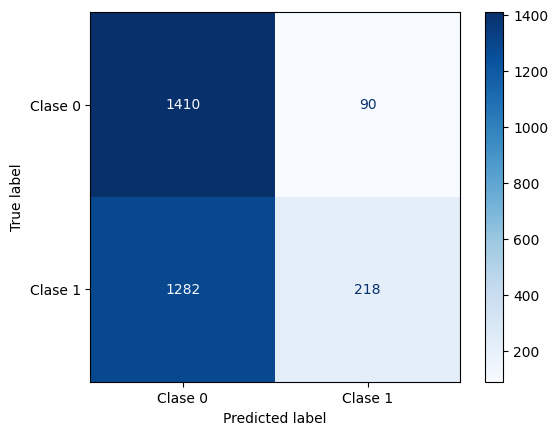

In [78]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, gracioso_numeric)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Clase 0", "Clase 1"])
disp.plot(cmap="Blues")

# Calcular métricas adicionales basadas en la matriz de confusión
precision = precision_score(y_test, gracioso_numeric)
recall = recall_score(y_test, gracioso_numeric)
f1 = f1_score(y_test, gracioso_numeric)

# Mostrar las métricas de la matriz de confusión
print("\nMétricas derivadas de la matriz de confusión:")
print(f" - Precisión: {precision:.4f}")
print(f" - Recall: {recall:.4f}")
print(f" - F1: {f1:.4f}")

El modelo de clasificación binaria obtuvo un F1-score del 24% aproximadamente, lo cual es un desempeño notablemente bajo para una tarea de clasificación binaria. Este resultado indica que el modelo tiene dificultades para diferenciar entre chistes graciosos y no graciosos, lo que puede estar relacionado con la naturaleza compleja y subjetiva del humor, así como con las características específicas del conjunto de datos.

En el caso del modelo LLM GPT-4o, su desempeño también se ve limitado debido a varios factores inherentes a la naturaleza del humor y las reglas bajo las cuales opera. En primer lugar, el conjunto de datos utilizado contiene textos mayoritariamente humorísticos obtenidos de fuentes como **Twitter**, donde los chistes suelen estar diseñados para un público específico y a menudo reflejan tendencias culturales, ironías o referencias contextuales que no son universales ni fácilmente interpretables por un modelo de lenguaje.

Además, una gran parte de los chistes en el conjunto de datos presentan **humor negro** o contenido que, aunque puede resultar gracioso para ciertos grupos, se encuentra en conflicto con las reglas éticas y los límites de seguridad impuestos a modelos como GPT-4o. Estas reglas están diseñadas para evitar la reproducción de contenidos que puedan ser ofensivos, insensibles o inapropiados, lo que lleva al modelo a interpretar estos textos con una perspectiva más neutral o incluso negativa, afectando su capacidad para clasificarlos como graciosos.

Este contraste pone de manifiesto cómo la naturaleza subjetiva del humor y las restricciones éticas pueden limitar el desempeño de los modelos, especialmente en dominios que requieren una comprensión cultural profunda y la capacidad de manejar temas delicados. La diferencia en accuracy resalta la necesidad de considerar cuidadosamente el contexto y las limitaciones al evaluar sistemas automáticos en tareas como la clasificación de humor.

# **PROYECTO HUMOR** Modelo Multiclase usando un LLM

**Autores:**

* Juan Camilo Acosta Rojas - 202324893
* Samuel Goncalves Vergara - 202122595
* Jefferson Hernández - 202120242
* Juan Andrés Mendez - 201815808

## **1. Carga de los datos**

Volvemos a generar un dataframe con los datos debido a que ahora se va a trabajar con la clasificación multiclase.

In [79]:
multi_dataset= pd.concat([df_graceful, df_non_graceful])
multi_dataset['promedio_gracioso'] = multi_dataset[['nivel_gracia_p1', 'nivel_gracia_p2', 'nivel_gracia_p3']].mean(axis=1).fillna(0).astype(int)
multi_dataset['Es_gracioso'] = multi_dataset['Es_gracioso'].fillna(0)

# Se muestra 5 ejemplos aleatorios del dataset donde la columna "promedio_gracioso" indica el nivel de chiste
print(multi_dataset.shape)
multi_dataset.sample(n=3)

(20000, 21)


,id,text,Fuente,es_gracioso_p1,es_gracioso_p2,es_gracioso_p3,Es_gracioso,nivel_gracia_p1,nivel_gracia_p2,nivel_gracia_p3,...,votes_no,votes_1,votes_2,votes_3,votes_4,votes_5,humor_rating,humor_mechanism,humor_target,promedio_gracioso
1752,1753,¿Por qué los hombres se sientan con las pierna...,Dataset_existente,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
9406,tweet14227,Hay personas que son como las monedas y no por...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,3.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0
1177,1178,"¡Papá, papá! en el colegio me ignoran. \n¡Papá...",Dataset_existente,1.0,1.0,0.0,1.0,1.0,3.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


## **2. Preprocesamiento de los datos**

Segundo, para el preprocesamiento usamos varios pasos. Primero se reemplazan URLs, menciones de usuarios, hashtags y emojis por tokens genéricos (<URL'>, <USUARIO'>, <HASH_TAG'>, <EMOJI'>), lo que reduce la dimensionalidad del texto sin perder contexto. Además, se convierte todo a minúsculas para uniformidad, se eliminan signos de puntuación y nombres de archivos irrelevantes.

In [80]:
multi_dataset['text'] = multi_dataset['text'].apply(preprocess_text)
multi_dataset = multi_dataset[['text', 'Es_gracioso', 'promedio_gracioso']]
multi_dataset.sample(n=3)

,text,Es_gracioso,promedio_gracioso
674,endoscopio preparo los examenes y decido q est...,1.0,1
8837,cinco años de loud y la reunión del cast ayer ...,0.0,0
294,nuestro amor era tan grande que hizo sus malet...,1.0,2


## **3. Partición de los datos**


Tercero, se realiza una revisión de la distribuión de los datos para verificar un correcto balanceo de las clases.

In [81]:
"""
Función para graficar la distribución de los datos
"""
def graficar_distribucion(class_counts):
    plt.figure(figsize=(6, 4))
    ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette="Blues_d", hue=class_counts.index)

    # Añadir los números sobre las barras
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    fontsize=12, color='black',
                    xytext=(0, 5), textcoords='offset points')

    plt.title("Distribución de Clases en el Conjunto de Datos")
    plt.xlabel("Clase")
    plt.ylabel("Número de Muestras")
    plt.xticks(rotation=0)
    plt.legend([], [], frameon=False)
    plt.show()

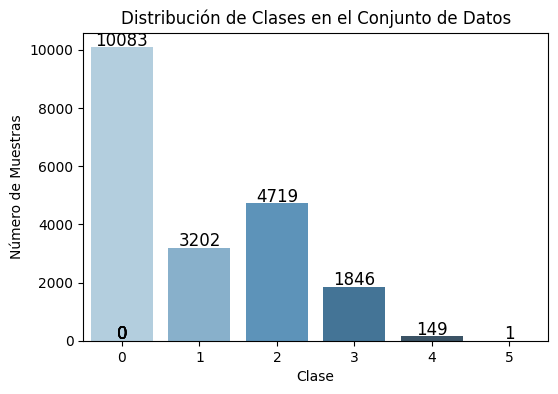

In [82]:
# Distribución inicial de los datos de cada clase
graficar_distribucion(multi_dataset['promedio_gracioso'].value_counts())

Se puede observar que hay un gran desbalanceo en las clases, para evitar este desbalanceo, se decidió limitar todas las clases a 2000 datos. Por otro lado, al tener la clase 4 y 5 pocos datos también se decidió por unificarlo con la clase 3, por ende, la clase 3, 4 y 5 corresponden a la misma clase.

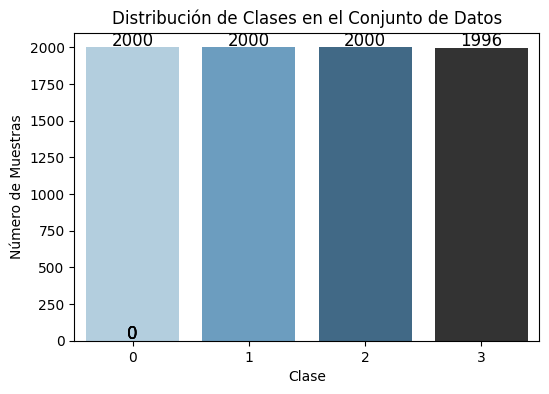

In [83]:
# Variable para definir el número máximo de datos en cada clase
max_samples_per_class = 2000

# Combinar las clases 4 y 5 en la clase 3
multi_dataset['promedio_gracioso'] = multi_dataset['promedio_gracioso'].replace({5: 4})
multi_dataset['promedio_gracioso'] = multi_dataset['promedio_gracioso'].replace({4: 3})

# Crear una lista para almacenar las muestras balanceadas
balanced_data = []

# Iterar sobre cada clase única en la columna 'promedio_gracioso'
for clase, datos_clase in multi_dataset.groupby('promedio_gracioso'):
    datos_balanceados = resample(
        datos_clase,
        replace=False,
        n_samples=min(max_samples_per_class, len(datos_clase)),
        random_state=2024
    )
    # Agregar los datos balanceados a la lista
    balanced_data.append(datos_balanceados)

# Combinar todas las muestras balanceadas en el DataFrame original
multi_dataset = pd.concat(balanced_data)

# Distribución final de los datos de cada clase
graficar_distribucion(multi_dataset['promedio_gracioso'].value_counts())

Una vez verificado el correcto balanceo de las clase, se hace la partición de los datos dejando un 70% de los datos para entrenamiento, un 15% de los datos para validación y un 15% de los datos para prueba.

In [84]:
# Divide el dataset original en un cojunto entrenamiento y un conjunto auxliar
X_train, X_aux, y_train, y_aux = train_test_split(
    multi_dataset['text'],
    multi_dataset['promedio_gracioso'],
    random_state=2024,
    test_size=0.3,
    stratify=multi_dataset['promedio_gracioso']
)

# Divide el conjunto auxiliar en un cojunto de prueba y un cojunto de validación
X_val, X_test, y_val, y_test = train_test_split(
    X_aux,
    y_aux,
    random_state=2024,
    test_size=0.5,
    stratify=y_aux
)

Se genera el dataset de la misma forma que el binario, y solo lo hacemos como los datos de testing por las mismas razones que se explicaron en el binario.

In [ ]:
X_test.to_excel('Predicciones_LLM_Multiclase.xlsx', index=False)

## **4. Generación predicciones usando LLM**

Para generar la clasificación lo que se hizo fue subir el archivo excel al modelo y user el siguiente prompt usando la técnica de few shot para mejorar los resultados:

In [96]:
# Combina las características y etiquetas del conjunto de prueba en un DataFrame
df_test = pd.DataFrame({'text': X_test, 'promedio_gracioso': y_test})

# Filtra y toma cinco ejemplos de cada clase para el primer DataFrame
df_clase_0 = df_test[df_test['promedio_gracioso'] == 0].sample(n=3)
df_clase_1 = df_test[df_test['promedio_gracioso'] == 1].sample(n=3)
df_clase_2 = df_test[df_test['promedio_gracioso'] == 2].sample(n=3)
df_clase_3 = df_test[df_test['promedio_gracioso'] == 3].sample(n=3)

# Crea dos DataFrames separados
df_ejemplos_clase_0 = df_clase_0.reset_index(drop=True)
df_ejemplos_clase_1 = df_clase_1.reset_index(drop=True)
df_ejemplos_clase_2 = df_clase_2.reset_index(drop=True)
df_ejemplos_clase_3 = df_clase_3.reset_index(drop=True)

# Tomamos los ejemplos de cada clase
ejemplos_clase_0 = df_ejemplos_clase_0['text'].tolist()
ejemplos_clase_1 = df_ejemplos_clase_1['text'].tolist()
ejemplos_clase_2 = df_ejemplos_clase_2['text'].tolist()
ejemplos_clase_3 = df_ejemplos_clase_3['text'].tolist()

# Construimos el prompt
prompt = f"""
El siguiente excel tiene una columna "text" donde hay diferentes datos de texto sobre contenido humorístico, necesito que clasifiques cada chiste con un número del 0 al 3 de acuerdo con su nivel de gracia.
Ejemplos:
###
Texto:{ejemplos_clase_0[0]}
Clasificación:0
###
Texto:{ejemplos_clase_0[1]}
Clasificación:0
###
Texto:{ejemplos_clase_0[2]}
Clasificación:0
###
Texto:{ejemplos_clase_1[0]}
Clasificación:1
###
Texto:{ejemplos_clase_1[1]}
Clasificación:1
###
Texto:{ejemplos_clase_1[2]}
Clasificación:1
###
Texto:{ejemplos_clase_2[0]}
Clasificación:2
###
Texto:{ejemplos_clase_2[1]}
Clasificación:2
###
Texto:{ejemplos_clase_2[2]}
Clasificación:2
###
Texto:{ejemplos_clase_3[0]}
Clasificación:3
###
Texto:{ejemplos_clase_3[1]}
Clasificación:3
###
Texto:{ejemplos_clase_3[2]}
Clasificación:3
###
"""
print(prompt)


El siguiente excel tiene una columna "text" donde hay diferentes datos de texto sobre contenido humorístico, necesito que clasifiques cada chiste con un número del 0 al 3 de acuerdo con su nivel de gracia.
Ejemplos:
###
Texto:tengo una amiga que está bien pendeja 
Clasificación:0
###
Texto:ay lavad
Clasificación:0
###
Texto:soy mal escritor pero yo decido a quién escribirle
Clasificación:0
###
Texto:si tú estás en un avión y éste se prende fuego por dónde sales
pues por las noticias
HASH_TAG HASH_TAG HASH_TAG
Clasificación:1
###
Texto:las fotos familiares siempre tienen alguien que sale mirando hacia otro lado al final todos aceptan la primera toma porque es la más natural y la abuela dice que no importa
Clasificación:1
###
Texto:usuario eso después de pedir a la mesera un bistec que tengo que accesar a las fuerzas que me quedan tras el laboro
Clasificación:1
###
Texto:no te deseo el mal pero ojalá que cuando estés pensando lo primero que se te venga a la cabeza sea una bala perdida
C

La respuesta fue:

`Voy a asignar un número del 0 al 3 a cada texto, donde 0 indica que no tiene gracia y 3 que es extremadamente gracioso. Este análisis será subjetivo y basado en el contenido textual. Comenzaré con el procesamiento. He evaluado el nivel de gracia de cada texto en una escala del 0 al 3. Puedes descargar el archivo con los resultados desde el siguiente enlace: Descargar archivo clasificado`

Cargamos el archivo generado por el LLM ya clasificado

In [97]:
gpt_multi = pd.read_excel('Xtestmulti_rated.xlsx')
gpt_multi.sample(n=5)

,text,Clasificación
304,dispensado,0
885,usuario en la web ya se refleja que la frecuen...,0
903,si dura 5 minutos más la entrevista de fani co...,0
729,tengo un don para imaginarme cosas que no está...,0
408,querer hablarle y a la vez no por no saber com...,0


Pasamos la columna del nivel_gracias a una lista para luego evaluar el modelo

In [99]:
# Convierte la columna 'gracioso' a una lista
gracioso_multi = gpt_multi['Clasificación'].tolist()

# Ahora, gracioso_numeric contiene la lista con 1s y 0s
print(gracioso_multi)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

## **5. Resultados**

Quinto, una vez teniendo los datos predecidos, calculamos las métricas del LLM para el caso de clasifiación multiclase mediante una matrix de confusión.


Métricas derivadas de la matriz de confusión:
 - Precisión (Weighted): 0.4639
 - Recall (Weighted): 0.2700
 - F1 (Weighted): 0.1410


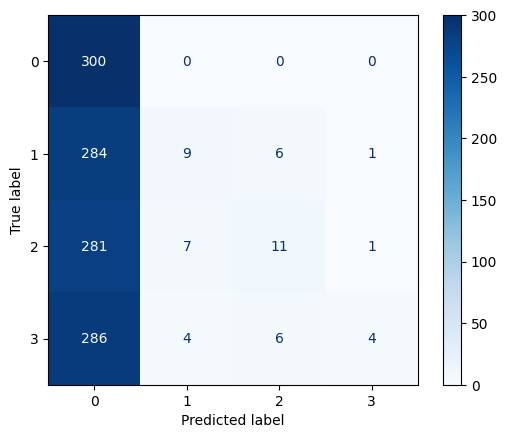

In [100]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, gracioso_multi)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

# Calcular métricas adicionales basadas en la matriz de confusión
precision = precision_score(y_test, gracioso_multi, average='weighted')
recall = recall_score(y_test, gracioso_multi, average='weighted')
f1 = f1_score(y_test, gracioso_multi, average='weighted')

# Mostrar las métricas de la matriz de confusión
print("\nMétricas derivadas de la matriz de confusión:")
print(f" - Precisión (Weighted): {precision:.4f}")
print(f" - Recall (Weighted): {recall:.4f}")
print(f" - F1 (Weighted): {f1:.4f}")

El clasificador multiclase basado en GPT-4o obtuvo un F1-score del 14%, lo que refleja un desempeño limitado en la tarea de clasificar chistes según su nivel de gracia en una escala de 0 a 3. Este resultado sugiere que el modelo enfrenta desafíos significativos en la interpretación del humor, especialmente en datos obtenidos de plataformas como Twitter, donde predominan referencias culturales, ironía y humor negro.

La clase 0 (no gracioso) fue la mejor identificada, con un bajo recall del 27% y con una baja precisión, lo que indica que el modelo tiende a clasificar muchos textos como no graciosos. Esto puede deberse a las restricciones éticas de GPT-4o, que priorizan respuestas conservadoras al interpretar textos potencialmente sensibles. En contraste, las clases intermedias (1, 2) tuvieron un bajo desempeño, con precisiones moderadas pero un recall prácticamente nulo, lo que refleja que el modelo tuvo dificultades para capturar los matices entre estas categorías.

Las clases superior (3, muy graciosos y extremadamente graciosos) fueron casi ignoradas, con métricas cercanas a cero debido a su baja frecuencia en los datos y la cautela del modelo al manejar este tipo de contenido. En general, las restricciones del modelo y la subjetividad inherente al humor explican los resultados dispares, destacando la necesidad de un enfoque especializado para tareas que involucran emociones y contexto cultural tan específicos.